# CS 436 Final Project

## Emanuel Hernandez

### Multi-class classifier on Toxic Comments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
train_data = train.drop(train.columns[0], axis=1)
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## EDA

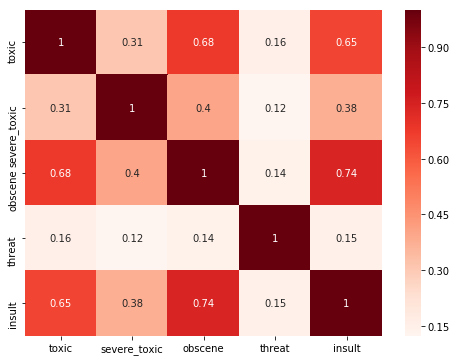

In [5]:
import seaborn as sns
temp_df=train.iloc[:,2:-1]

confusion_matrix = temp_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix,
            xticklabels=confusion_matrix.columns.values,
            yticklabels=confusion_matrix.columns.values, 
            annot=True,
            cmap="Reds")

there is a high correlation between obscene comments and insults as well as some correlation in toxic and obscene.

<Figure size 864x720 with 0 Axes>

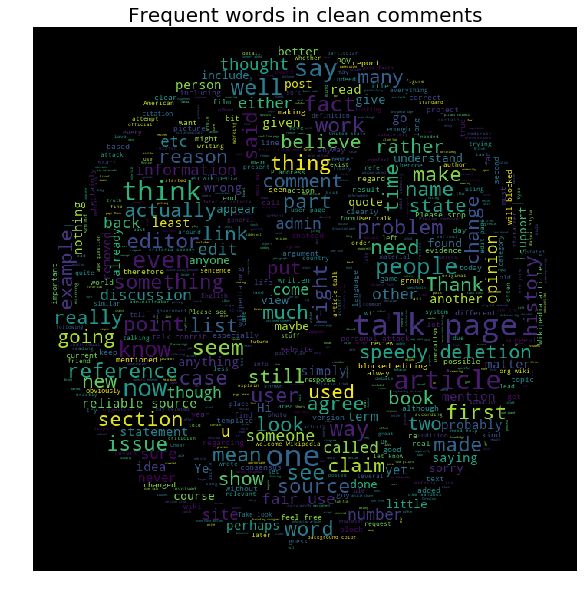

In [29]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

p_mask = np.array(Image.open("toxic.jpg"))
p_mask = p_mask[:,:,:1] #only taking the first value of 3rd array
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean'] = (rowsums==0)
subset = train[train.clean==True]
text = subset.comment_text.values
plt.figure(figsize=(12,10))
wc = WordCloud(background_color="black", max_words=2000, mask=p_mask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(text))
plt.figure(figsize=(12,10))
plt.axis('off')
plt.title("Frequent words in clean comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=7), alpha=1)
plt.show()

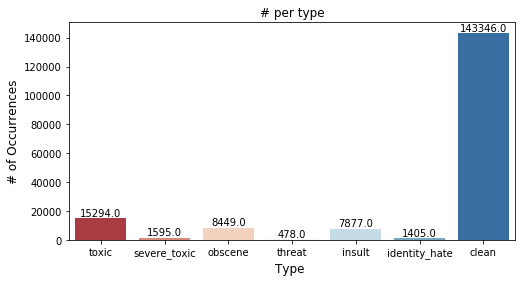

In [8]:
counts = train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax = sns.barplot(counts.index, counts.values, palette='RdBu')
plt.title("# per type")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')

plt.show()

We can see that most of the comments in the training data set are clean... only a small percentage of them are actually 'mean' comments

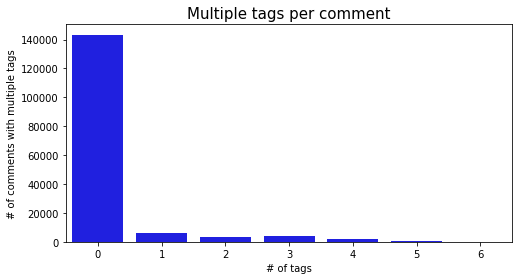

In [9]:
q = rowsums.value_counts()
plt.figure(figsize=(8,4))
ax = sns.barplot(q.index, q.values, color='blue')
plt.title("Multiple tags per comment", fontsize=15)
plt.ylabel("# of comments with multiple tags", fontsize=10)
plt.xlabel("# of tags", fontsize=10)
plt.show()

In [10]:
for values, amounts in zip(q.index, q.values):
    print(values, amounts)

0 143346
1 6360
3 4209
2 3480
4 1760
5 385
6 31


## Data Cleaning

In [11]:
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### Now, I have to clean the dataset by:

* removing tabs and \n (regex)
* convert to lower case all the comments
* remove stopwords
* removing ip addresses within comments (regex)

In [14]:
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')

def clean_data(df):
    #transform to lowercase
    df['comment_text'] = df['comment_text'].str.lower()
    #removing \n
    df['comment_text'] = df['comment_text'].apply(lambda x: re.sub("\n"," ",x))
    #removing IP addresses
    df['comment_text'] = df['comment_text'].apply(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x))
    #removing usernames
    df['comment_text'] = df['comment_text'].apply(lambda x: re.sub("\[\[.*\]","",x))
    df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edgardocastro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
train_data = clean_data(train_data)
train_data.shape

(159571, 7)

In [16]:
test_data = pd.read_csv('test.csv')
labels = pd.read_csv('test_labels.csv')

#negative_ones = labels[labels['toxic']==-1] #not used for testing
#labels = labels.drop(negative_ones.index, axis=0) #getting rid of comments not used for testing
#test_data = test_data[test_data.id.isin(labels.id)] #only keep comments used for testing
#test['comment_text'] = test_data['comment_text']
#test = test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

test_data = clean_data(test_data)

## Training/Testing with TF-IDF and Logistic Regression

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

comment_text = pd.concat([train_data.comment_text, test_data.comment_text])

tfidf = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode', #strip accents from characters.
    analyzer='word', #can also use character
    ngram_range=(1, 1),
    max_features=5000)

tfidf.fit(comment_text)

train_word_features = tfidf.transform(train_data.comment_text)
test_word_features = tfidf.transform(test_data.comment_text)

In [18]:
#train_word_features.todense()[10:30]
# tfidf.vocabulary_
# train_word_features.todense()[0]

# df_cvec = pd.DataFrame(X_train_cvec.todense(),columns=cvec.get_feature_names())
# print df_cvec.shape
# df_cvec.head()

q = train_data.comment_text[0]
s = len(q.split(' '))

for comment in train_data.comment_text:
    temp = len(comment.split(' '))
    shortest = min(s, temp)
    longest = max(s, temp)
    
shortest, longest

(23, 25)

In [19]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [20]:
results = pd.DataFrame.from_dict({'id': test_data['id']})

In [21]:
from sklearn.linear_model import LogisticRegression

for class_name in classes:
    train_target = train[class_name]
    clf = LogisticRegression(C=1, solver='sag', random_state=7)
    clf.fit(train_word_features, train_target)
    results[class_name] = clf.predict_proba(test_word_features)[:, 1]

In [22]:
results.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.996111,0.233139,0.993503,0.026516,0.924177,0.209147
1,0000247867823ef7,0.011434,0.002953,0.005377,0.001288,0.008145,0.004043
2,00013b17ad220c46,0.015363,0.001620,0.006661,0.000784,0.010885,0.002292
3,00017563c3f7919a,0.005296,0.002732,0.004394,0.001267,0.003404,0.001157
4,00017695ad8997eb,0.032775,0.004621,0.005187,0.001207,0.009565,0.002091


In [23]:
#results.to_csv('submission.csv', encoding='utf-8', index=False)

## Using LSTM in Keras

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

max_features = 20000
maxlen = 180

tokenizer = Tokenizer(num_words=max_features)
y = train_data[classes].values

tokenizer.fit_on_texts(list(train_data.comment_text))
list_tokenized_train = tokenizer.texts_to_sequences(train_data.comment_text)
list_tokenized_test = tokenizer.texts_to_sequences(test_data.comment_text)

#pad is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 
#in the beginning of each sequence until each sequence has the same length as the longest sequence.
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

y_test = labels[classes].values

seq_input = Input(shape=(maxlen, )) #a vector of 180 values
embed_size = 128

#max_features is size of vocabulary in text data
#embed_size is the size of the vector space in which words will be embedded
x = Embedding(max_features, embed_size)(seq_input) #reaches the actual words through vocabulary from pad_sequences
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.15))(x) #will execute this computation given x
x = GlobalMaxPool1D()(x)
x = Dense(40, activation="relu")(x)
x = Dropout(0.1)(x) #regularization technique, randomly selected neurons are ignored during training
x = Dense(6, activation="sigmoid")(x) #predict either a 1 or 0
model = Model(seq_input,x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(X_train, y, epochs=1, batch_size=1024, validation_data=(X_test, y_test))

#y_pred = model.predict(X_test, batch_size=1024)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 159571 samples, validate on 153164 samples
Epoch 1/1
159571/159571 [==============================] - 1010s 6ms/step - loss: 0.1508 - acc: 0.9612 - val_loss: -2.6767 - val_acc: 0.4037
